<h1>Convolutional Neural Networks</h1>
<br>
<img src="https://miro.medium.com/max/2000/1*1TI1aGBZ4dybR6__DI9dzA.png" width="900" align="center">

<br><br>
In this lab we will be constructing and training a "Convolutional Neural Network" aka a neural network that contains convolution kernels with learnable parameters.<br>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data.dataloader as dataloader

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

# Import our custom module!
from Network import LeNet

In [2]:
# The size of our mini batches
batch_size = 64
# How many itterations of our dataset
num_epochs = 20
# Optimizer learning rate
learning_rate = 1e-4
# Where to load/save the dataset from 
data_set_root = "../../datasets"

In [3]:
# Set device to GPU_indx if GPU is avaliable
gpu_indx = 0
device = torch.device(gpu_indx if torch.cuda.is_available() else 'cpu')

<h3> Create a transform for the input data </h3>
As we have seen, we often wish to perform some operations on data before we pass it through our model. Such operations could be, cropping or resizing images, affine transforms and data normalizations. Pytorch's torchvision module has a large number of such "transforms" which can be strung together sequentially using the "Compose" function. <br>

Pytorch's inbuilt datasets take a transform as an input and will apply this transform to the data before passing it to you! This makes preprocessing data really easy! We will see more about data preprocessing in a later lab!

[torchvision.transforms](https://pytorch.org/vision/0.9/transforms.html#)

In [4]:
# Prepare a composition of transforms
# transforms.Compose will perform the transforms in order
# NOTE: some transform only take in a PIL image, others only a Tensor
# EG Resize and ToTensor take in a PIL Image, Normalize takes in a Tensor
# Refer to documentation
transform = transforms.Compose([
            transforms.Resize(32),
            transforms.ToTensor(),
            transforms.Normalize([0.1307], [0.308])])

# Note: ToTensor() will scale unit8 and similar type data to a float and re-scale to 0-1
# Note: We are normalizing with the dataset mean and std 

<h3> Create the training, testing and validation data</h3>
When training many machine learning systems it is best practice to have our TOTAL dataset split into three segments, the training set, testing set and validation set. Up until now we have only had a train/test set split and have used the test set to gauge the performance during training. Though for the most "unbiased" results we should really not use our test set until training is done! So if we want to evaluate our model on an "unseen" part of the dataset we need another split - the validation set. <br><br>
<b>Training set</b>   - the data we train our model on<br>
<b>Validation set</b> - the data we use to gauge model performance during training<br>
<b>Testing set</b>   - the data we use to "rate" our trained model<br>

In [5]:
# Define our MNIST Datasets
# Can also try with CIFAR10 Dataset
# https://pytorch.org/docs/stable/torchvision/datasets.html#mnist
train_data = datasets.MNIST(data_set_root, train=True, download=True, transform=transform)
test_data = datasets.MNIST(data_set_root, train=False, download=True, transform=transform)

# We are going to split the test dataset into a train and validation set 90%/10%
validation_split = 0.9

# Determine the number of samples for each split
n_train_examples = int(len(train_data)*validation_split)
n_valid_examples = len(train_data) - n_train_examples

# The function random_split will take our dataset and split it randomly and give us dataset
# that are the sizes we gave it
# Note: we can split it into to more then two pieces!
train_data, valid_data = torch.utils.data.random_split(train_data, [n_train_examples, n_valid_examples],
                                                       generator=torch.Generator().manual_seed(42))

# IMPORTANT TO KNOW!!!!!!!!!
# Here we pass the random_split function a manual seed, this is very important as if we did not do this then 
# everytime we randomly split our training and validation set we would get different splits!!!
# For example if we saved our model and reloaded it in the future to train some more, the dataset that we now use to
# train with will undoubtably contain datapoints that WERE in the validation set initially!!
# Our model would therefore be trained with both validation and training data -- very bad!!!
# Setting the manual seed to the same value everytime prevents this!

<h3> Create our model and view the ouput! </h3>

In [6]:
# Create an instance of our network
model = LeNet(channels_in=1,
              device=device, loss_fun=nn.CrossEntropyLoss(),
              batch_size=batch_size, learning_rate=learning_rate).to(device)

model.set_data(train_set=train_data, test_set=test_data, val_set=valid_data)
# View the network
# Note that the layer order is simply the order in which we defined them, NOT the order of the forward pass
print(model)

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000
LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=400, out_features=120, bias=True)
  (linear2): Linear(in_features=120, out_features=84, bias=True)
  (linear3): Linear(in_features=84, out_features=10, bias=True)
  (loss_fun): CrossEntropyLoss()
)


In [8]:
# Create a dataloader itterable object
dataiter = iter(model.test_loader)
# Sample from the itterable object
test_images, test_labels = next(dataiter)

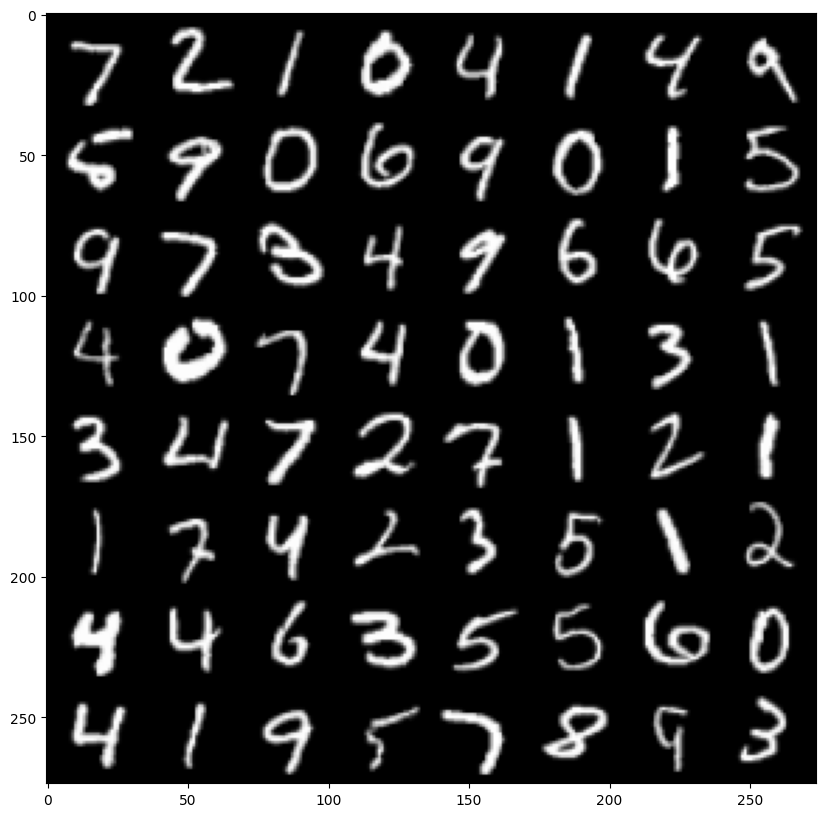

In [9]:
# Lets visualise an entire batch of images!
plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(test_images, 8, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

In [10]:
# Pass image through network
out = model(test_images.to(device))
# Check output
out.shape

torch.Size([64, 10])

In [ ]:
# This cell implements our training loop
for epoch in trange(num_epochs, leave=False, desc="Epoch"):
    # Call the modules training function
    model.train_model()
    
    # Call the modules evaluate function for train and validation set
    _ = model.evaluate_model(train_test_val="train")
    _ = model.evaluate_model(train_test_val="val")

print("Training Complete")

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/844 [00:00<?, ?it/s]

In [ ]:
plt.figure(figsize = (10,10))
train_x = np.linspace(0, num_epochs, len(model.train_loss_logger))
plt.plot(train_x, model.train_loss_logger)
plt.title("LeNet Training Loss")

In [ ]:
plt.figure(figsize = (10,10))
train_x = np.linspace(0, num_epochs, len(model.train_acc_logger))
plt.plot(train_x, model.train_acc_logger, c = "y")
valid_x = np.linspace(0, num_epochs, len(model.val_acc_logger))
plt.plot(valid_x, model.val_acc_logger, c = "k")

plt.title("LeNet")
plt.legend(["Training accuracy", "Validation accuracy"])

# Evaluate

In [ ]:
# Call the evaluate function and pass the evaluation/test dataloader etc
test_acc = model.evaluate_model(train_test_val="test")

print("The total test accuracy is: %.2f%%" %(test_acc*100))

In [ ]:
# Lets visualise the prediction for a few test images!
with torch.no_grad():
    fx = model(test_images[:8].to(device))
    pred = fx.argmax(-1)
    
plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(test_images[:8], 8, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

print("Predicted Values\n", list(pred.cpu().numpy()))
print("True Values\n", list(test_labels[:8].numpy()))